In [1]:
import os
path = '/kaggle/input/dataset-zip-textsumary/dataset_textsummary/ViMs/'
data_mulpti_document = []  # thằng này là data của các cluster, mỗi cluster lại có nhiều document
target_0 = [] # thằng này là nhãn summary của cluster do user 0 tạo ra
path_original = path + 'original/'
path_summary = path + 'summary/'
path_original_files = [path_original + file for file in os.listdir(path_original)]
path_summary_files = [path_summary + file for file in os.listdir(path_summary)]
path_original_files = [file + '/original' for file in path_original_files]
# 1 cluster (original) lại có nhiều file txt, mỗi txt chứa 1 document
for file in path_original_files:
    data = []
    for txt in os.listdir(file):
        with open(file + '/' + txt, 'r', encoding= 'utf-8' ) as f:
            text = f.read()
            text = text.split('Content:')[1]
            text = text.replace('\n', '')
            # print(type(text))
            data.append(text)
    data_mulpti_document.append(data)

path_summary_files_0 = [file + '/0.gold.txt' for file in path_summary_files]


for file in path_summary_files_0:
    with open(file, 'r', encoding= 'utf-8' ) as f:
        text = f.read()
        target_0.append(text)


print(len(data_mulpti_document))

print(len(target_0))






300
300


In [2]:
!pip install lexrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 3.8 MB/s eta 0:00:00


In [3]:
from lexrank import LexRank
lxr = LexRank(data_mulpti_document)
data_summary = []
#hàm tách các câu trong đoạn văn bằng dấu .
def split_data(data):
    data = data.split('.')
    return data
for i in range(len(data_mulpti_document)):
    data = ''
    for j in range(len(data_mulpti_document[i])):
        sumary = lxr.get_summary(data_mulpti_document[i][j], summary_size=3, threshold=.1)
        for k in range(len(sumary)):
            data += sumary[k]
    data_summary.append(data)

train_data = data_summary[:int(len(data_summary)*0.8)]
train_target = target_0[:int(len(data_summary)*0.8)]
val_data = data_summary[int(len(data_summary)*0.8):int(len(data_summary)*0.9)]
val_target = target_0[int(len(data_summary)*0.8):int(len(data_summary)*0.9)]
test_data = data_summary[int(len(data_summary)*0.9):]
test_target = target_0[int(len(data_summary)*0.9):]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import matplotlib.pyplot as plt
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = {'train':Dataset.from_dict({'document':train_data,'summary':train_target}),
     'val':Dataset.from_dict({'document':val_data,'summary':val_target}),
     'test':Dataset.from_dict({'document':test_data,'summary':test_target})
     }

In [5]:
dataset

{'train': Dataset({
     features: ['document', 'summary'],
     num_rows: 240
 }),
 'val': Dataset({
     features: ['document', 'summary'],
     num_rows: 30
 }),
 'test': Dataset({
     features: ['document', 'summary'],
     num_rows: 30
 })}

In [6]:
# load thu vien transformer
!pip install transformers

In [7]:
from transformers import  AutoTokenizer,MBartForConditionalGeneration

model_ckpt = "vinai/bartpho-syllable"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = MBartForConditionalGeneration.from_pretrained(model_ckpt)

In [8]:
%%time
d_len = [len(tokenizer.encode(s)) for s in dataset["val"]["document"]]
s_len = [len(tokenizer.encode(s)) for s in dataset["val"]["summary"]]

CPU times: user 35.6 ms, sys: 75 µs, total: 35.7 ms
Wall time: 37.6 ms


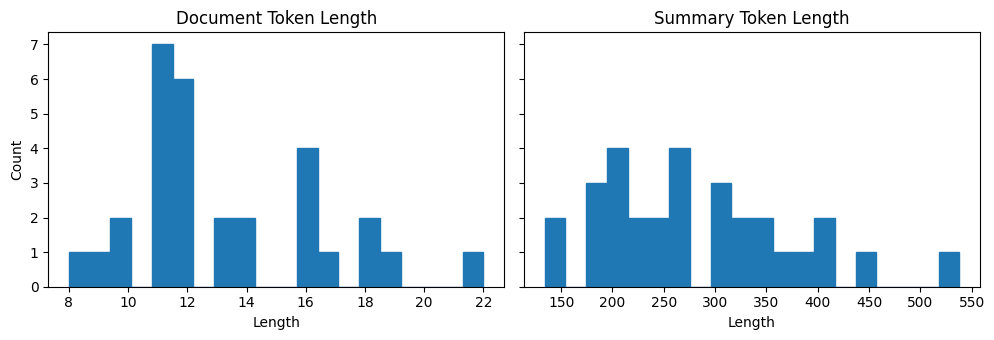

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Document Token Length")
axes[0].set_xlabel("Length")

axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [10]:
input_encodings_train = tokenizer(dataset["train"]["document"], max_length=1024, truncation=True)
with tokenizer.as_target_tokenizer():
    target_encodings_train = tokenizer(dataset["train"]["summary"],max_length=256,truncation = True)
# dataset_tf = {'train':Dataset.from_dict({'input_ids':input_encodings["input_ids"]})}
input_encodings_val = tokenizer(dataset["val"]["document"], max_length=1024, truncation=True)
with tokenizer.as_target_tokenizer():
    target_encodings_val = tokenizer(dataset["val"]["summary"],max_length=256,truncation = True)
input_encodings_test = tokenizer(dataset["test"]["document"], max_length=1024, truncation=True)
with tokenizer.as_target_tokenizer():
    target_encodings_test = tokenizer(dataset["test"]["summary"],max_length=256,truncation = True)
dataset_tf = {'train':Dataset.from_dict({'input_ids':input_encodings_train["input_ids"],
                                        'attention_mask':input_encodings_train["attention_mask"],
                                        'labels': target_encodings_train["input_ids"]}),
             'val':Dataset.from_dict({'input_ids':input_encodings_val["input_ids"],
                                     'attention_mask':input_encodings_val["attention_mask"],
                                     'labels': target_encodings_val["input_ids"]}),
             'test':Dataset.from_dict({'input_ids':input_encodings_test["input_ids"],
                                      'attention_mask':input_encodings_test["attention_mask"],
                                      'labels': target_encodings_test["input_ids"]})}

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [11]:
!pip install transformers[torch]

In [12]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0


In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir='bart-multi-news', num_train_epochs=1, warmup_steps=500,
                                  per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                  weight_decay=0.01, logging_steps=10, push_to_hub=False,
                                  evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
                                  gradient_accumulation_steps=16)

In [14]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [15]:
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_tf["train"],
                  eval_dataset=dataset_tf["val"])

trainer.train()

UsageError: api_key not configured (no-tty). call wandb.login(key=[your_api_key])

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
sample_text = dataset["test"][2]["document"]
reference = dataset["test"][2]["summary"]

input_ids = tokenizer(sample_text, max_length=1024, truncation=True,
                   padding='max_length', return_tensors='pt').to(device)
summaries = model.generate(input_ids=input_ids['input_ids'],
                           attention_mask=input_ids['attention_mask'],
                           max_length=256,num_beams = 10)

decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                      clean_up_tokenization_spaces=True)
                    for s in summaries]

print("Document:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(decoded_summaries)

In [ ]:
!pip install rouge

In [ ]:
### đánh giá (rounge1, rouge2, rougeL, rougeLsum)
from rouge import Rouge
rouge = Rouge()
rouge1 = []
rouge2 = []
rougeL = []
rougeLsum = []
for i in range(len(test_data)):
    input_ids = tokenizer.encode(test_data[i], max_length=1024, truncation=True,
                   padding='max_length', return_tensors='pt').to(device)
    summaries = model.generate(input_ids=input_ids['input_ids'],
                           attention_mask=input_ids['attention_mask'],
                           max_length=256,num_beams = 10)
    decoded = [tokenizer.decode(s, skip_special_tokens=True,
                                      clean_up_tokenization_spaces=True)
                    for s in summaries]
    scores = rouge.get_scores(decoded[0], test_target[i])
    rouge1.append(scores[0]['rouge-1']['f'])
    rouge2.append(scores[0]['rouge-2']['f'])
    rougeL.append(scores[0]['rouge-l']['f'])
    rougeLsum.append(scores[0]['rouge-l-sum']['f'])
print('rouge1: ', sum(rouge1)/len(rouge1))
print('rouge2: ', sum(rouge2)/len(rouge2))
print('rougeL: ', sum(rougeL)/len(rougeL))
print('rougeLsum: ', sum(rougeLsum)/len(rougeLsum))
